15.089260413714934
번호: 0
71


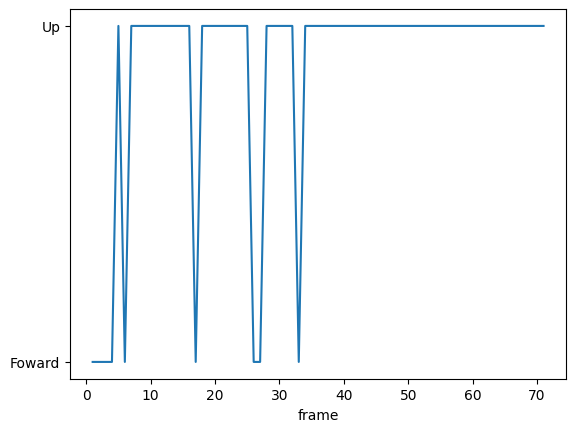

In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import numpy as np
import time
import csv
for i in range(1):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

    mp_drawing = mp.solutions.drawing_utils

    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)


    cap = cv2.VideoCapture('/Users/김태형/Desktop/video/forward_H_0527/forward18.mp4'.format(i))

    #Set Video File Property
    videoFileName = 'output.avi'
    w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # width
    h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #height
    fps = cap.get(cv2.CAP_PROP_FPS) #frame per second
    fourcc = cv2.VideoWriter_fourcc(*'DIVX') #fourcc
    delay = round(1000/fps) #set interval between frame
    print(fps)
    #Save Video
    out = cv2.VideoWriter(videoFileName, fourcc, fps, (w,h))

    Angle_list = []
    len_list=[]
    direction_list = []
    x_y_z_list=[]

    while cap.isOpened():
        success, image = cap.read()
        if success:
            #out.write(image)

            start = time.time()

            direction = 1

            # Flip the image horizontally for a later selfie-view display
            # Also convert the color space from BGR to RGB
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            # To improve performance
            image.flags.writeable = False
            
            # Get the result
            results = face_mesh.process(image)
            
            # To improve performance
            image.flags.writeable = True
            
            # Convert the color space from RGB to BGR
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            img_h, img_w, img_c = image.shape
            face_3d = []
            face_2d = []

            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    for idx, lm in enumerate(face_landmarks.landmark):
                        if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                            if idx == 1:
                                nose_2d = (lm.x * img_w, lm.y * img_h)
                                nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                            x, y = int(lm.x * img_w), int(lm.y * img_h)

                            # Get the 2D Coordinates
                            face_2d.append([x, y])

                            # Get the 3D Coordinates
                            face_3d.append([x, y, lm.z])       
                    
                    # Convert it to the NumPy array
                    face_2d = np.array(face_2d, dtype=np.float64)

                    # Convert it to the NumPy array
                    face_3d = np.array(face_3d, dtype=np.float64)

                    # The camera matrix
                    focal_length = 1 * img_w

                    cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                            [0, focal_length, img_w / 2],
                                            [0, 0, 1]])

                    # The distortion parameters
                    dist_matrix = np.zeros((4, 1), dtype=np.float64)

                    # Solve PnP
                    success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                    # Get rotational matrix
                    rmat, jac = cv2.Rodrigues(rot_vec)

                    # Get angles
                    angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

                    # Get the y rotation degree
                    x = angles[0] * 360
                    y = angles[1] * 360
                    z = angles[2] * 360
                

                    # See where the user's head tilting
                    if y < -10:
                        text = "Looking Left"
                        direction = "Left"
                    elif y > 10:
                        text = "Looking Right"
                        direction = "Right"
                    elif x < -10:
                        text = "Looking Down"
                        direction = "Down"
                    elif x > 10:
                        text = "Looking Up"
                        direction = "Up"
                    else:
                        text = "Forward"
                        direction = "Foward"

                    # Display the nose direction
                    nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

                    p1 = (int(nose_2d[0]), int(nose_2d[1]))
                    p2 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - x * 10))
                    
                    cv2.line(image, p1, p2, (255, 0, 0), 3)

                    # Add the text on the image
                    cv2.putText(image, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
                    cv2.putText(image, "x: " + str(np.round(x,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    cv2.putText(image, "y: " + str(np.round(y,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    cv2.putText(image, "z: " + str(np.round(z,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                
                direction_list.append(direction)
                x_y_z_list.append([x, y, z])
                

                end = time.time()
                totalTime = end - start

                fps = 1 / totalTime
                #print("FPS: ", fps)

                cv2.putText(image, f'FPS: {int(fps)}', (20,450), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)

                mp_drawing.draw_landmarks(
                            image=image,
                            landmark_list=face_landmarks,
                            connections=mp_face_mesh.FACEMESH_CONTOURS,
                            landmark_drawing_spec=drawing_spec,
                            connection_drawing_spec=drawing_spec)
            


            cv2.imshow('Head Pose Estimation', image)

            if cv2.waitKey(5) & 0xFF == 27:
                break
            out.write(image)
        else:
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print('번호:', i)

    x = [i+1 for i in range(len(direction_list))]
    print(len(x))
    plt.plot(x, direction_list)
    plt.xlabel("frame")
    plt.show()

    import csv
    with open('/Users/김태형/Desktop/Final_project/csv/foward/foward_ha_{0}.csv'.format(i), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(x_y_z_list)
